In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from rasterio.features import shapes
from shapely.geometry import Polygon, MultiPolygon, Point, LineString
from shapely.affinity import scale

plt.rcParams["figure.figsize"] = (10,10)


In [3]:

def clean_img(img, kernel_size = 5, iterations = 5):
    '''
    clean_img : 
        uses morphological operations to clean the image, in this case uses erosion to remove 
        extremly small items, and dilation to go back to original shape and closess some holes,
        different combination provide diifferent results
    
    docs: https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html
    
    img:  threshhold image
    kernel_size: the size of the morph kernel in pixels 5 by default, by default uses rectangle as a shape
    iterations: nb of times operations are applied
    
    returns 
        img: cleaned image
    '''
    
    kernel_s = np.ones((2, 2),np.uint8)
    img = cv2.erode(img, kernel_s, iterations = iterations)
    
    kernel_1 = np.ones((kernel_size, kernel_size),np.uint8)
    img = cv2.erode(img, kernel_1, iterations = iterations)
    img = cv2.dilate(img, kernel_1, iterations = iterations)
    
    return img

def contours_extraction(img):
    '''
    Basic contour extraction from threshold image
    
    img: img
    
    returns
        ctr: list of all extracted contours,
        h: containes hierarchical information about every contour, 
            for every contour [nextCtr_id, prevCtr_id, FirstChildCtr_id, parentCtr_id ]
    '''
    
    ctr, h = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return ctr, h[0]
    
def contour_data(cnt, epsilon = 0.001):
    '''
    Extracts some useful informations from a contour like mass center, area and perimeter, more features can be extracted 
    using cv2.moments
    Also simplifies the contours
    
    cnt: single contour,
    epsilon: simplification strength 
    
    returns
        area: area of contour will be used for filtering
        approx: simplified polygon 
    '''
    
    M = cv2.moments(cnt)

    #cx = int(M['m10']/M['m00'])
    #cy = int(M['m01']/M['m00'])
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt,True)

    epsilon = epsilon * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon,True)
    
    return area, approx
    

def classify_contour(h, idx, cls_dict):
    '''
    classifies the contour, on either region of room
    for the given contour if there is no parent then the contour is a region, else is room
    
    h: contourss hierarchical features
    idx: index of the contour to classify
    cls_dict: dictionnary containing classification of the different contours
    
    returns
        updated classification dict
    
    '''
    
    p_idx = h[idx][3]
    p_p_idx = h[p_idx][3]
    
    if p_idx not in cls_dict:
        if p_p_idx == -1:
            p_cls = 0
        else:
            cls_dict = classify_contour(h, idx, cls_dict)
            p_cls = cls_dict[p_idx]
    else:
        p_cls = cls_dict[p_idx]
        
    cls = p_cls + 1
    cls_dict[idx] = cls
    
    return cls_dict
    

# Main function to extract the road mask
def generate_regions(img, 
                     clean_func=clean_img, 
                     ctr_func=contours_extraction, 
                     ctr_data=contour_data, 
                     max_area=10000, 
                     min_area=200,
                     kernel_size=5,
                     iterations = 5,
                     epsilon = 0.001):
    
    '''
    Generate the regions and rooms from an image
    
    img: thresholded image
    clean_func: function to clean the image
    ctr_fnc: function for contour extractio
    ctr_data: function for extracting useful informations from a contour
    max_area: max area for fileterig very big contours
    min_area: are of minimum possible contour
    kernel_size :: should be replaced b **kwags
    iterations :: should be replaced b **kwags
    epsilon :: should be replaced b **kwags
    
    
    returns
        img: cleaned img
        ctr: all extracted contours
        regions: classified regions
        rooms: classified rooms
    '''
    
    img = clean_func(img, kernel_size, iterations) # start by cleaning the img
    ctr, h = ctr_func(img) # extract contours and hierarchical data
    
    classes_dict = dict()
    approxs = [None] * len(ctr)
    
    for i in range(len(ctr)): #classify contours
        cnt = ctr[i]
        #cnt_area, approx = ctr_data(cnt, epsilon)
        cnt_area, approxs[i] = ctr_data(cnt, epsilon)
        # If area is very small or very big then, thea features are useless...
        if cnt_area < max_area and cnt_area > min_area:
            classes_dict = classify_contour(h, i, classes_dict)
        else:
            classes_dict[i] = -1

    
    base_region_idx = 0 if len(list(classes_dict.values())) < 2 else min([i for i in list(classes_dict.values()) if i >= 0])
    regions = [approxs[i] for i in range(len(ctr)) if classes_dict[i] == base_region_idx and h[i][2] != -1]
    rooms = [approxs[i] for i in range(len(ctr)) if classes_dict[i] > base_region_idx]
    
    return img, ctr, classes_dict, regions, rooms


In [4]:
img = cv2.imread('./test.png', flags=cv2.IMREAD_GRAYSCALE)
img_th = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY_INV)[1]

In [22]:

kernel_size = 3
epsilon = 0.0001

img_area = img.shape[0] * img.shape[1]
max_area = 0.8*img_area
min_area = 400

img_cleaned, all_ctrs, classes_dict, regions, rooms =  generate_regions(img=img_th, max_area=max_area, min_area=min_area, kernel_size=kernel_size, epsilon=epsilon)


# Viz

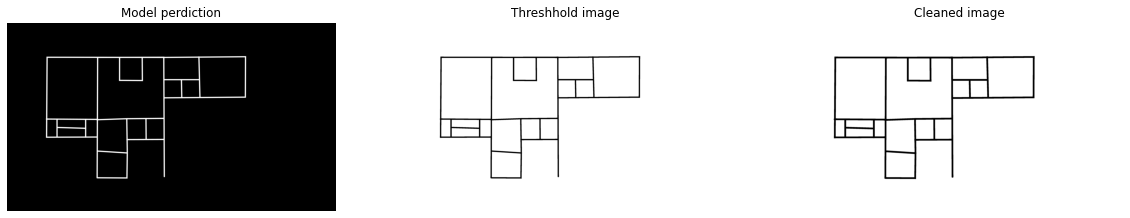

In [23]:
f, ax = plt.subplots(1,3, figsize=(20, 14))    


ax[0].imshow(img, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Model perdiction')
    
ax[1].imshow(img_th, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Threshhold image')

ax[2].imshow(img_cleaned, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Cleaned image')

plt.show()

f.savefig('fig1.jpg')

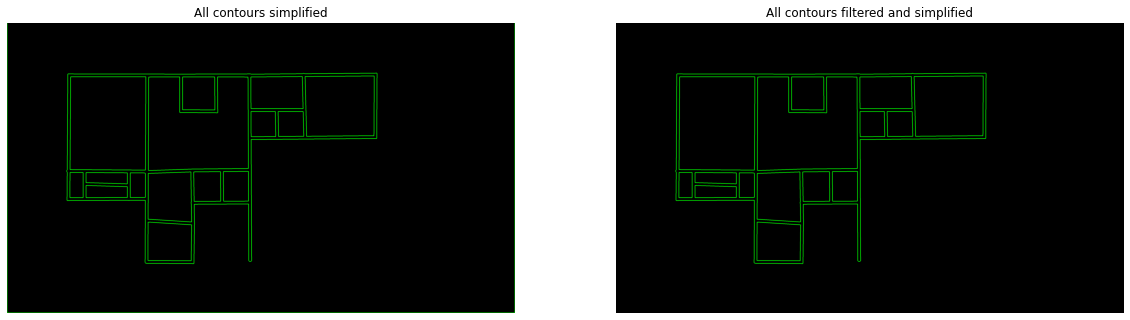

In [24]:
all_ctrs_img = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
cv2.drawContours(all_ctrs_img, all_ctrs, -1, (0, 255, 0), 3)

filtered_ctrs_img = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
for region in regions + rooms:
    cv2.drawContours(filtered_ctrs_img, [region], -1, (0, 255, 0), 3)
    

f, ax = plt.subplots(1,2, figsize=(20, 14))

ax[0].imshow(all_ctrs_img)
ax[0].axis('off')
ax[0].set_title('All contours simplified')

ax[1].imshow(filtered_ctrs_img)
ax[1].axis('off')
ax[1].set_title('All contours filtered and simplified')

plt.show()
f.savefig('fig2.jpg')

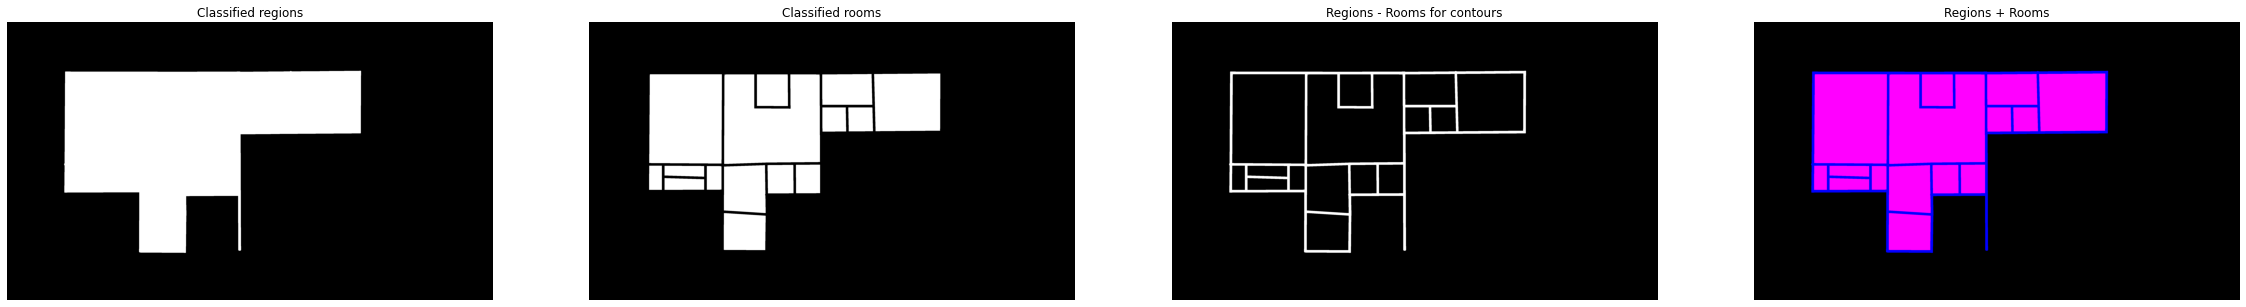

In [25]:
all_regions_img = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)

regions_img = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
for region in regions:
    cv2.fillPoly(regions_img, [region], (255, 255, 255))
    cv2.fillPoly(all_regions_img, [region], (0, 0, 255))
    
rooms_img = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
for region in rooms:
    cv2.fillPoly(rooms_img, [region], (255, 255, 255))
    cv2.fillPoly(all_regions_img, [region], (255, 0, 255))
    

f, ax = plt.subplots(1,4, figsize=(40, 25))

ax[0].imshow(regions_img)
ax[0].axis('off')
ax[0].set_title('Classified regions')

ax[1].imshow(rooms_img)
ax[1].axis('off')
ax[1].set_title('Classified rooms')

ax[2].imshow(regions_img - rooms_img)
ax[2].axis('off')
ax[2].set_title('Regions - Rooms for contours')

ax[3].imshow(all_regions_img)
ax[3].axis('off')
ax[3].set_title('Regions + Rooms')

plt.show()
f.savefig('fig3.jpg')

# Room analysis


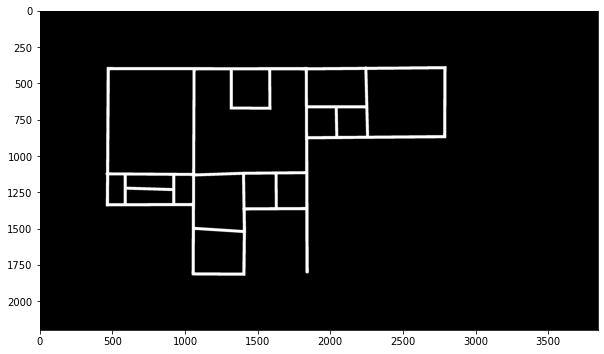

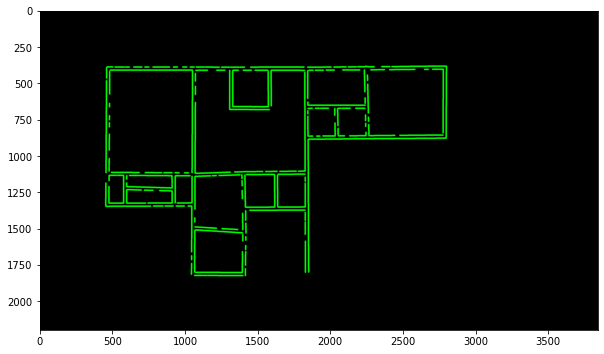

In [26]:
#Useless
only_walls = regions_img - rooms_img
plt.imshow(only_walls)
plt.show()

canny_img = np.zeros((only_walls.shape[0], only_walls.shape[1], 3), np.uint8)


edges = cv2.Canny(only_walls,50,150,apertureSize = 3)
lines = cv2.HoughLinesP(edges,1,np.pi/180,0,minLineLength=20,maxLineGap=10)
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(canny_img,(x1,y1),(x2,y2),(0,255,0),10)


plt.imshow(canny_img)
plt.show()

In [27]:
#making rooms and regions into Shapely format
rooms_polygons = [Polygon(np.squeeze(i)).simplify(5) for i in rooms]
regions_polygons = [Polygon(np.squeeze(i)).simplify(5).difference(MultiPolygon(rooms_polygons)) for i in regions]

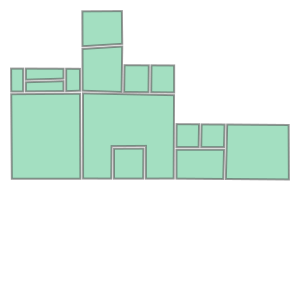

In [28]:
MultiPolygon(rooms_polygons)

In [29]:
#Experiment with buffer for dilation and erosion +. chaining simplification,
# Runing a chain of simplificatioin 5-5-5 will provide better result and preserves shape better than one simplificaation 15....., 

#MultiPolygon([Polygon(np.squeeze(i)).buffer(7).buffer(-7).simplify(5).simplify(7).simplify(10) for i in rooms])

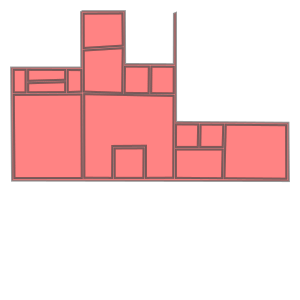

In [30]:
MultiPolygon(regions_polygons + rooms_polygons)

In [31]:

def check_point_in_polys(polys, p):
    found = False
    for poly in polys:
        if poly.contains(Point(p[0], p[1])):
            found = True
            return found
    return found
    
def check_line_in_polys(polys, p1, p2, ignore):
    found = False
    for i in range(len(polys)):
        poly = polys[i]
        if i != ignore and poly.intersects(LineString([(p1[0], p1[1]), (p2[0], p2[1])])):
            found = True
            return found
    return found


def create_rooms(rooms, regions, isSegment=False, iterations=10, scale_factor=1.05):
    keep_indices = dict()
    final_rooms = rooms
    final_rooms_arr = [np.array(r.exterior.coords) for r in final_rooms]
    
    for val in range(len(final_rooms_arr)):
        keep_indices[val] = list(range(len(final_rooms_arr[val])))
    
    for i in range(iterations):
        
        #rooms_dilated = [r.buffer(padding, resolution=-100, cap_style=2, join_style=2) for r in final_rooms]
        rooms_scaled = [scale(r, xfact=scale_factor, yfact=scale_factor, origin='center') for r in final_rooms]
        
        
        for j in range(len(rooms_scaled)):
            #dilated_room = np.array(rooms_dilated[j].exterior.coords)
            scaled_room = np.array(rooms_scaled[j].exterior.coords)
            
            for p in range(len(scaled_room)):
                if j in keep_indices and p in keep_indices[j]:
                    point = scaled_room[p]
                    
                    next_idx = p+1 if len(scaled_room) > p+2 else 0
                    point_next = point if not isSegment else scaled_room[next_idx]
                    
                    is_in_regions = check_point_in_polys(regions, point) if not isSegment else check_line_in_polys(regions, point, point_next, j)
                    if is_in_regions:
                        
                        final_rooms_arr[j][p] = point
                        if isSegment:
                            final_rooms_arr[j][next_idx] = point_next
                            
                        is_in_other_rooms = check_point_in_polys(rooms_scaled, point) if not isSegment else check_line_in_polys(rooms_scaled, point, point_next, j)
                        if is_in_other_rooms:
                            keep_indices[j].remove(p)
                            if isSegment and next_idx in keep_indices[j]:
                                keep_indices[j].remove(next_idx) 

        final_rooms = [Polygon(new_room) for new_room in final_rooms_arr]
        #print('iteration ', i, ' finished')
    
    return final_rooms

In [32]:
import time
start = time.time()

cleand_rooms = create_rooms(rooms_polygons, regions_polygons, False, 20, 1.01)
end = time.time()
print(end - start)

0.30664777755737305


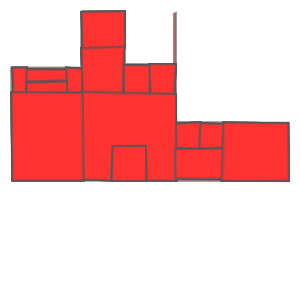

In [33]:
MultiPolygon(regions_polygons + cleand_rooms * 6 )

In [34]:
#Experiment Simple fnuction for extraction sifferetn wall segments .....

def generate_linear_analysis(room_original, room_cleaned):
    walls = []
    original_rooms_arr = np.array(room_original.exterior.coords)
    room_cleaned_arrr = np.array(room_cleaned.exterior.coords)
    
    for i in range(len(original_rooms_arr)):
        next_i = i+1 if len(original_rooms_arr) > i+1 else 0
        
        p0 = original_rooms_arr[i]
        p1 = room_cleaned_arrr[i]
        p2 = room_cleaned_arrr[next_i]
        p3 = original_rooms_arr[next_i]
        walls.append(Polygon([p0, p1 ,p2, p3]))
        
    return walls

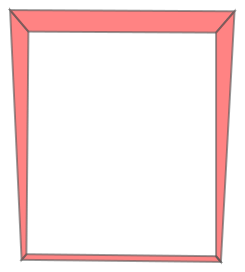

In [35]:

ii = 7
walls = generate_linear_analysis(rooms_polygons[ii], cleand_rooms[ii])
MultiPolygon(walls)